In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn', silent=True)
fact = Reasoner.from_onto(onto, timeout=None)
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
C = onto.concept_by_name
R = onto.role_by_name
onto

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
rng = np.random.default_rng(seed)
Nc = onto.n_concepts
Nr = onto.n_roles
gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)
        
n_queries = 32_000
queries, answers, qset = [], [], set()
while len(queries) < n_queries:
    axiom = gen()
    axiom_core = core(axiom)
    if axiom_core in qset: continue
    answer = fact.check_axiom(axiom)
    queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
    
print(onto.render(queries[100]))
print(len(answers))
print(np.round(np.mean(answers), 4))

LeekTopping ⊑ SpicyPizzaEquivalent
32000
0.411


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

rng = np.random.default_rng(seed)

params = dict(emb_size=10, hidden_size=16, onto=onto)

T.manual_seed(seed)
unfrozen_r = ModifiedNeuralReasoner(**params)

T.manual_seed(seed)
transfer_r = ModifiedNeuralReasoner(**params)
transfer_r.head.load_state_dict(T.load('local/out/exp/20240630T144632/reasoner.pt'))

T.manual_seed(seed)
random_r = ModifiedNeuralReasoner(**params)

params = dict(epoch_count=20, batch_size=32, lr_reasoner=0.001, lr_encoder=0.001)

print('unfrozen reasoner head')
T.manual_seed(seed)
unfrozen_log = train_mod(data, None, unfrozen_r.head, [unfrozen_r.embs], run_name='unfrozen', **params, not_nn_loss_weight=100, and_nn_loss_weight=50)

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data, None, transfer_r.head, [transfer_r.embs], freeze_reasoner=True, run_name='frozen transfer', **params, not_nn_loss_weight=100, and_nn_loss_weight=50)

print('----')

print('frozen reasoner head (random)')
T.manual_seed(seed)
random_log = train_mod(data, None, random_r.head, [random_r.embs], freeze_reasoner=True, run_name='frozen random', **params, not_nn_loss_weight=100, and_nn_loss_weight=50)

unfrozen reasoner head
train epoch 00/20 | batch 1001/1000 | loss 4.1701 | val loss 0.7068 | acc 0.4110 | f1 0.5826 | prec 0.4110 | recall 1.0000 | roc auc 0.3471 | pr auc 0.3214 | elapsed 25.80s
train epoch 01/20 | batch 1001/1000 | loss 1.6499 | val loss 0.2844 | acc 0.8882 | f1 0.8628 | prec 0.8703 | recall 0.8554 | roc auc 0.9486 | pr auc 0.9306 | elapsed 36.94s
train epoch 02/20 | batch 1001/1000 | loss 1.5043 | val loss 0.1895 | acc 0.9269 | f1 0.9106 | prec 0.9159 | recall 0.9054 | roc auc 0.9767 | pr auc 0.9682 | elapsed 35.56s
train epoch 03/20 | batch 1001/1000 | loss 1.5395 | val loss 0.1591 | acc 0.9399 | f1 0.9271 | prec 0.9248 | recall 0.9294 | roc auc 0.9831 | pr auc 0.9766 | elapsed 36.25s
train epoch 04/20 | batch 1001/1000 | loss 1.4800 | val loss 0.1113 | acc 0.9625 | f1 0.9541 | prec 0.9594 | recall 0.9489 | roc auc 0.9910 | pr auc 0.9881 | elapsed 35.94s
train epoch 05/20 | batch 1001/1000 | loss 1.3241 | val loss 0.0901 | acc 0.9709 | f1 0.9642 | prec 0.9763 | rec

In [6]:
print('unfrozen reasoner head')
T.manual_seed(seed)
unfrozen_r.head.intertrain_not_and()

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_r.head.intertrain_not_and()

print('----')

print('frozen reasoner head (random)')
T.manual_seed(seed)
random_r.head.intertrain_not_and()

unfrozen reasoner head
loss:  tensor(0.0947, grad_fn=<AddBackward0>)
loss:  tensor(0.0061, grad_fn=<AddBackward0>)
loss:  tensor(3.4841e-05, grad_fn=<AddBackward0>)
loss:  tensor(5.0524e-10, grad_fn=<AddBackward0>)
loss:  tensor(1.5192e-09, grad_fn=<AddBackward0>)
loss:  tensor(1.5144e-07, grad_fn=<AddBackward0>)
loss:  tensor(1.4112, grad_fn=<AddBackward0>)
loss:  tensor(0.0243, grad_fn=<AddBackward0>)
loss:  tensor(0.0398, grad_fn=<AddBackward0>)
loss:  tensor(0.1072, grad_fn=<AddBackward0>)
loss:  tensor(0.0286, grad_fn=<AddBackward0>)
----
frozen reasoner head (transfer)
loss:  tensor(0.0112, grad_fn=<AddBackward0>)
loss:  tensor(3.9120e-10, grad_fn=<AddBackward0>)
loss:  tensor(7.5992e-10, grad_fn=<AddBackward0>)
loss:  tensor(2.5482e-07, grad_fn=<AddBackward0>)
loss:  tensor(6.8239e-09, grad_fn=<AddBackward0>)
loss:  tensor(1.0424e-10, grad_fn=<AddBackward0>)
loss:  tensor(0.0307, grad_fn=<AddBackward0>)
loss:  tensor(0.0086, grad_fn=<AddBackward0>)
loss:  tensor(0.0065, grad_fn=

In [7]:
params = dict(epoch_count=10, batch_size=32, lr_reasoner=0.001, lr_encoder=0.001)

print('unfrozen reasoner head')
T.manual_seed(seed+1)
unfrozen_log = train_mod(data, None, unfrozen_r.head, [unfrozen_r.embs], run_name='unfrozen', **params, not_nn_loss_weight=100, and_nn_loss_weight=50, top_bot_weight=25, train_top_bot=True)

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed+1)
transfer_log = train_mod(data, None, transfer_r.head, [transfer_r.embs], freeze_reasoner=True, run_name='frozen transfer', **params, not_nn_loss_weight=100, and_nn_loss_weight=50, top_bot_weight=25, train_top_bot=True)

print('----')

print('frozen reasoner head (random)')
T.manual_seed(seed+1)
random_log = train_mod(data, None, random_r.head, [random_r.embs], freeze_reasoner=True, run_name='frozen random', **params, not_nn_loss_weight=100, and_nn_loss_weight=50, top_bot_weight=25, train_top_bot=True)

unfrozen reasoner head
train epoch 00/10 | batch 1001/1000 | loss 7.6662 | val loss 0.2509 | acc 0.9244 | f1 0.9026 | prec 0.9598 | recall 0.8517 | roc auc 0.9771 | pr auc 0.9714 | elapsed 43.97s
train epoch 01/10 | batch 1001/1000 | loss 5.8940 | val loss 0.0408 | acc 0.9880 | f1 0.9854 | prec 0.9864 | recall 0.9845 | roc auc 0.9988 | pr auc 0.9984 | elapsed 56.39s
train epoch 02/10 | batch 1001/1000 | loss 5.6179 | val loss 0.0363 | acc 0.9891 | f1 0.9868 | prec 0.9851 | recall 0.9884 | roc auc 0.9990 | pr auc 0.9986 | elapsed 54.99s
train epoch 03/10 | batch 1001/1000 | loss 6.0968 | val loss 0.0347 | acc 0.9892 | f1 0.9869 | prec 0.9835 | recall 0.9903 | roc auc 0.9991 | pr auc 0.9988 | elapsed 54.68s
train epoch 04/10 | batch 1001/1000 | loss 6.6191 | val loss 0.0301 | acc 0.9904 | f1 0.9883 | prec 0.9901 | recall 0.9865 | roc auc 0.9994 | pr auc 0.9991 | elapsed 59.16s
train epoch 05/10 | batch 1001/1000 | loss 6.9418 | val loss 0.0284 | acc 0.9908 | f1 0.9889 | prec 0.9856 | rec

------
Unfrozen reasoner head
train time 482.29530692100525
             mean  std     micro
acc      0.992000  NaN  0.992000
prec     0.987378  NaN  0.987378
recall   0.993233  NaN  0.993233
f1       0.990297  NaN  0.990297
auc_roc  0.999633  NaN  0.999633
auc_pr   0.999489  NaN  0.999489
------
Frozen pre-trained reasoner head
train time 409.9020097255707
             mean  std     micro
acc      0.957844  NaN  0.957844
prec     0.945367  NaN  0.945367
recall   0.952482  NaN  0.952482
f1       0.948911  NaN  0.948911
auc_roc  0.988808  NaN  0.988808
auc_pr   0.983010  NaN  0.983010
------
Frozen random reasoner head
train time 429.90823340415955
             mean  std     micro
acc      0.786469  NaN  0.786469
prec     0.686057  NaN  0.686057
recall   0.885882  NaN  0.885882
f1       0.773269  NaN  0.773269
auc_roc  0.844702  NaN  0.844702
auc_pr   0.736410  NaN  0.736410


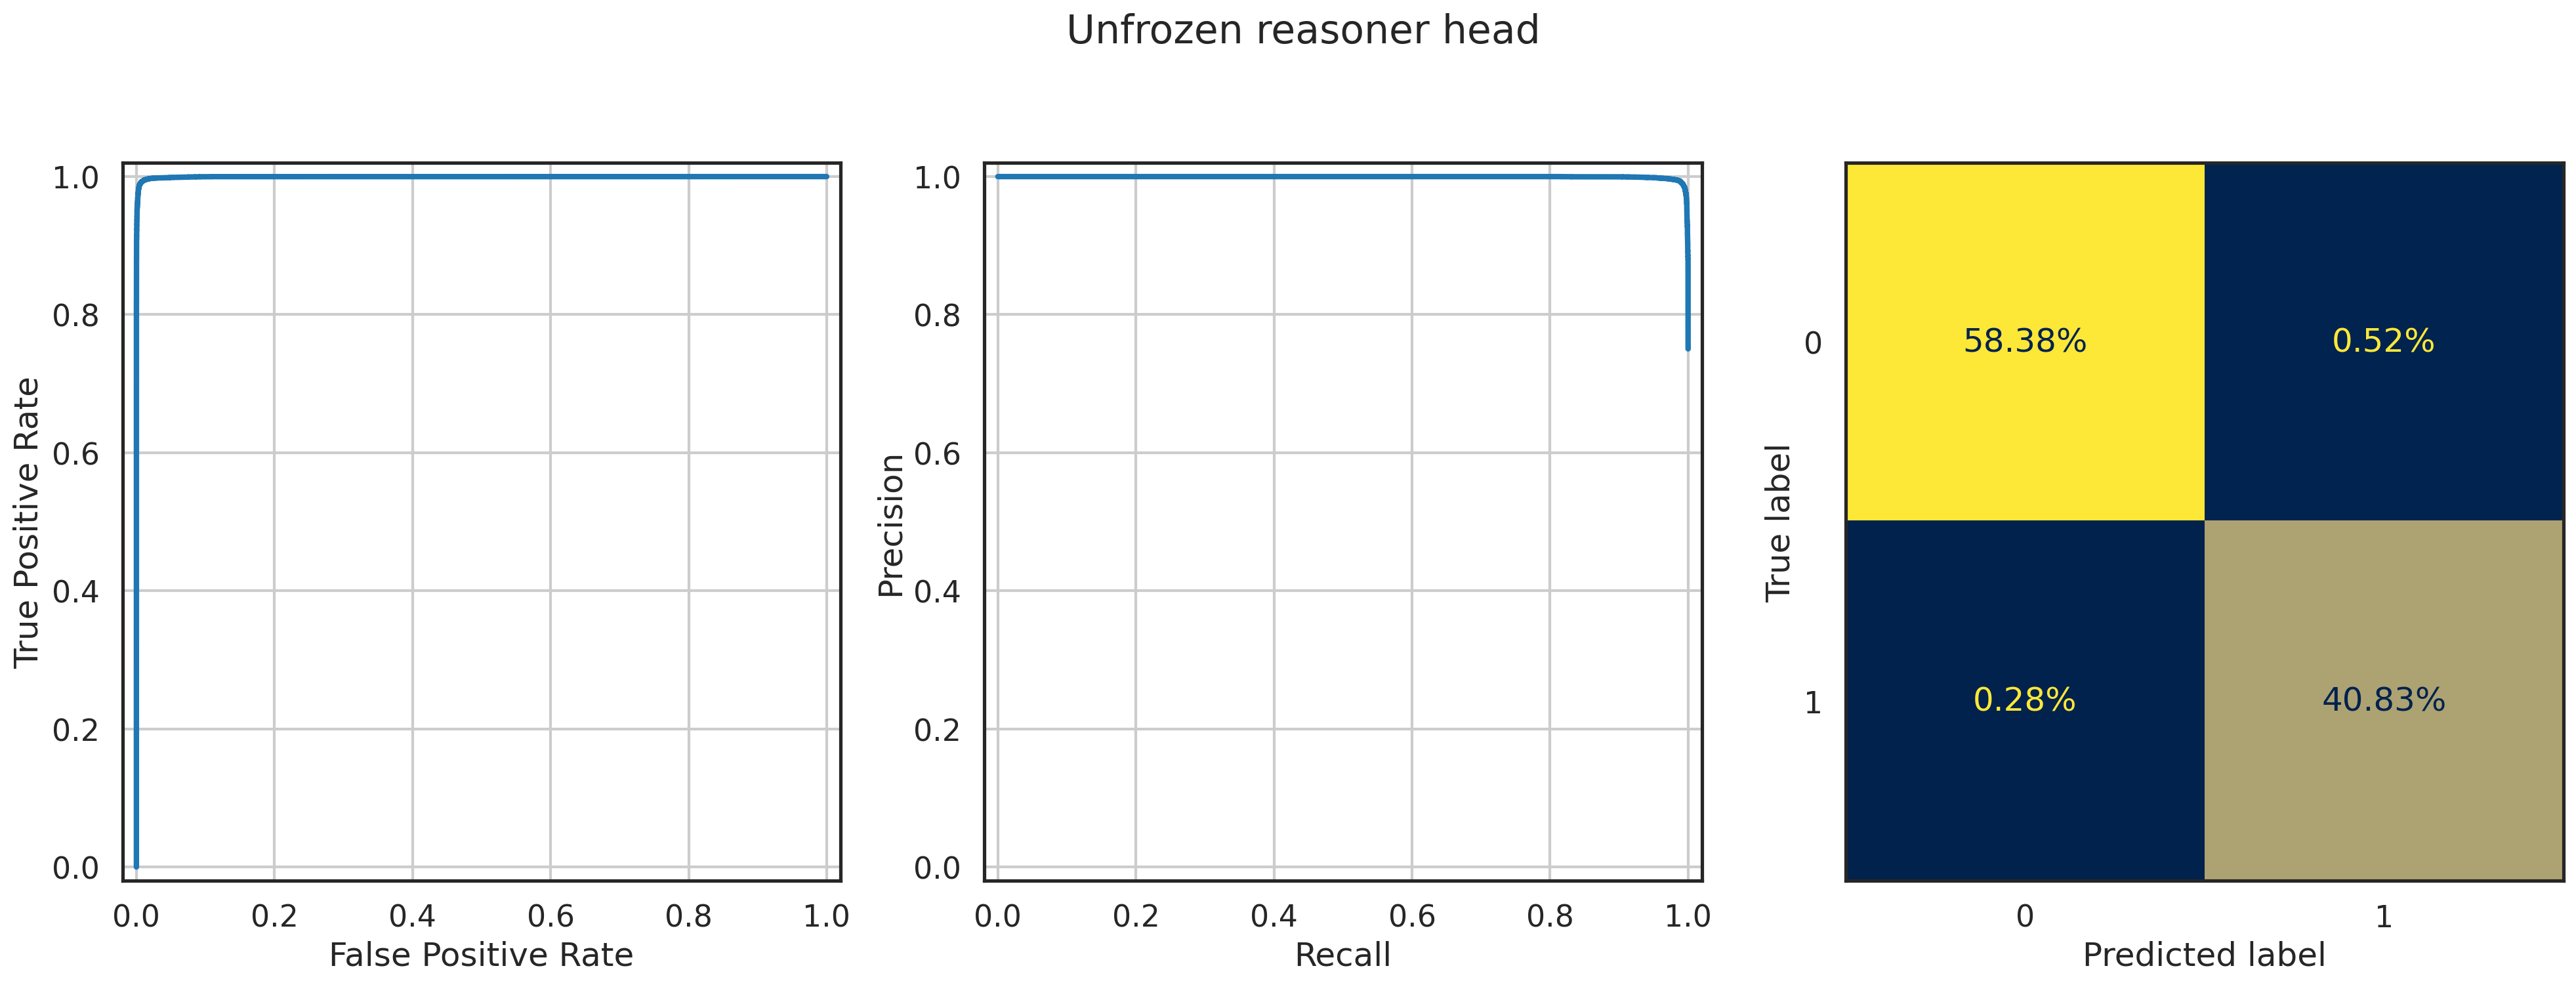

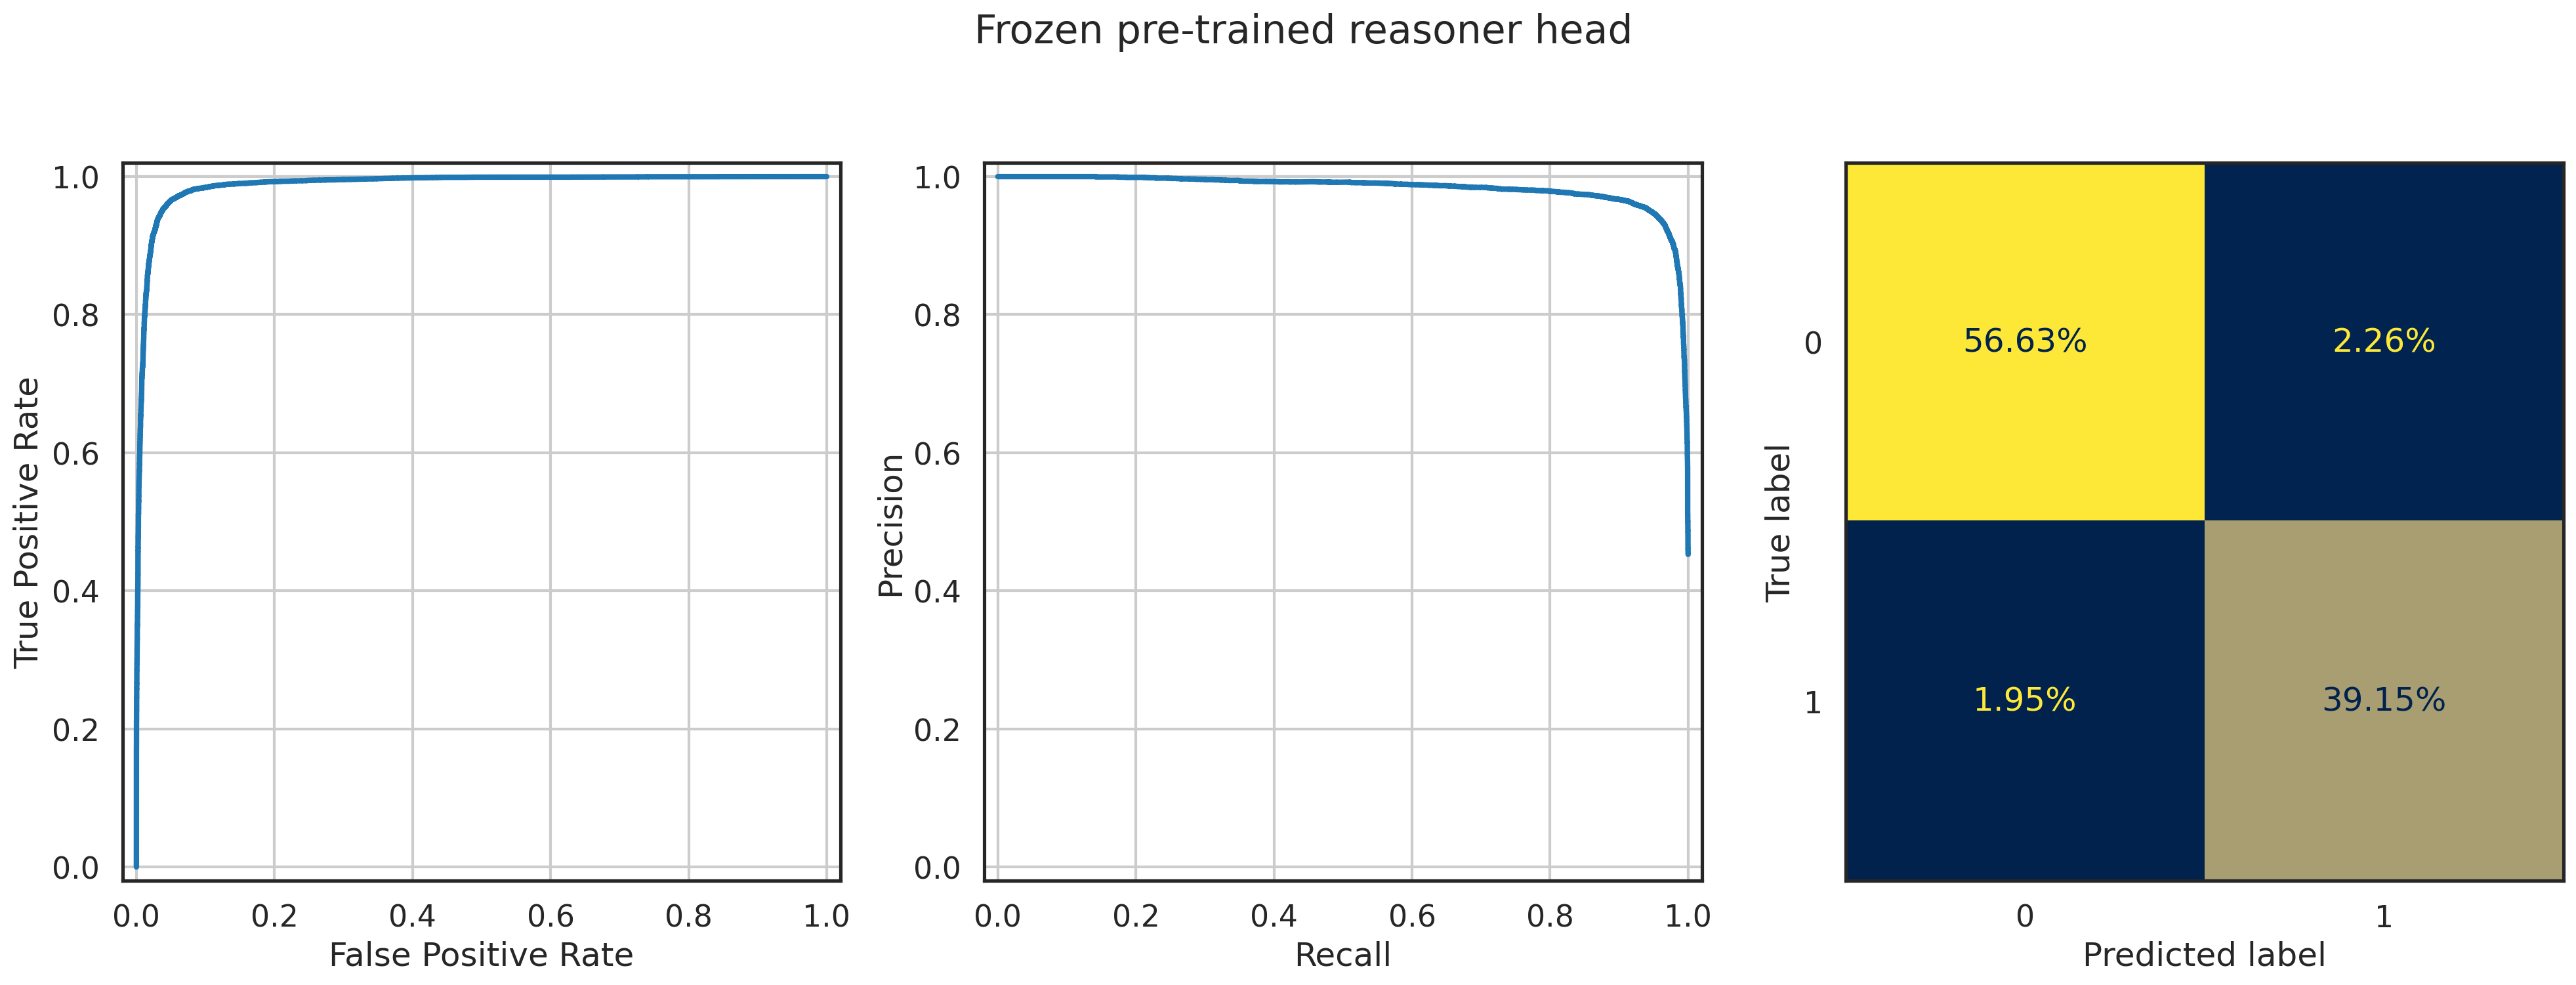

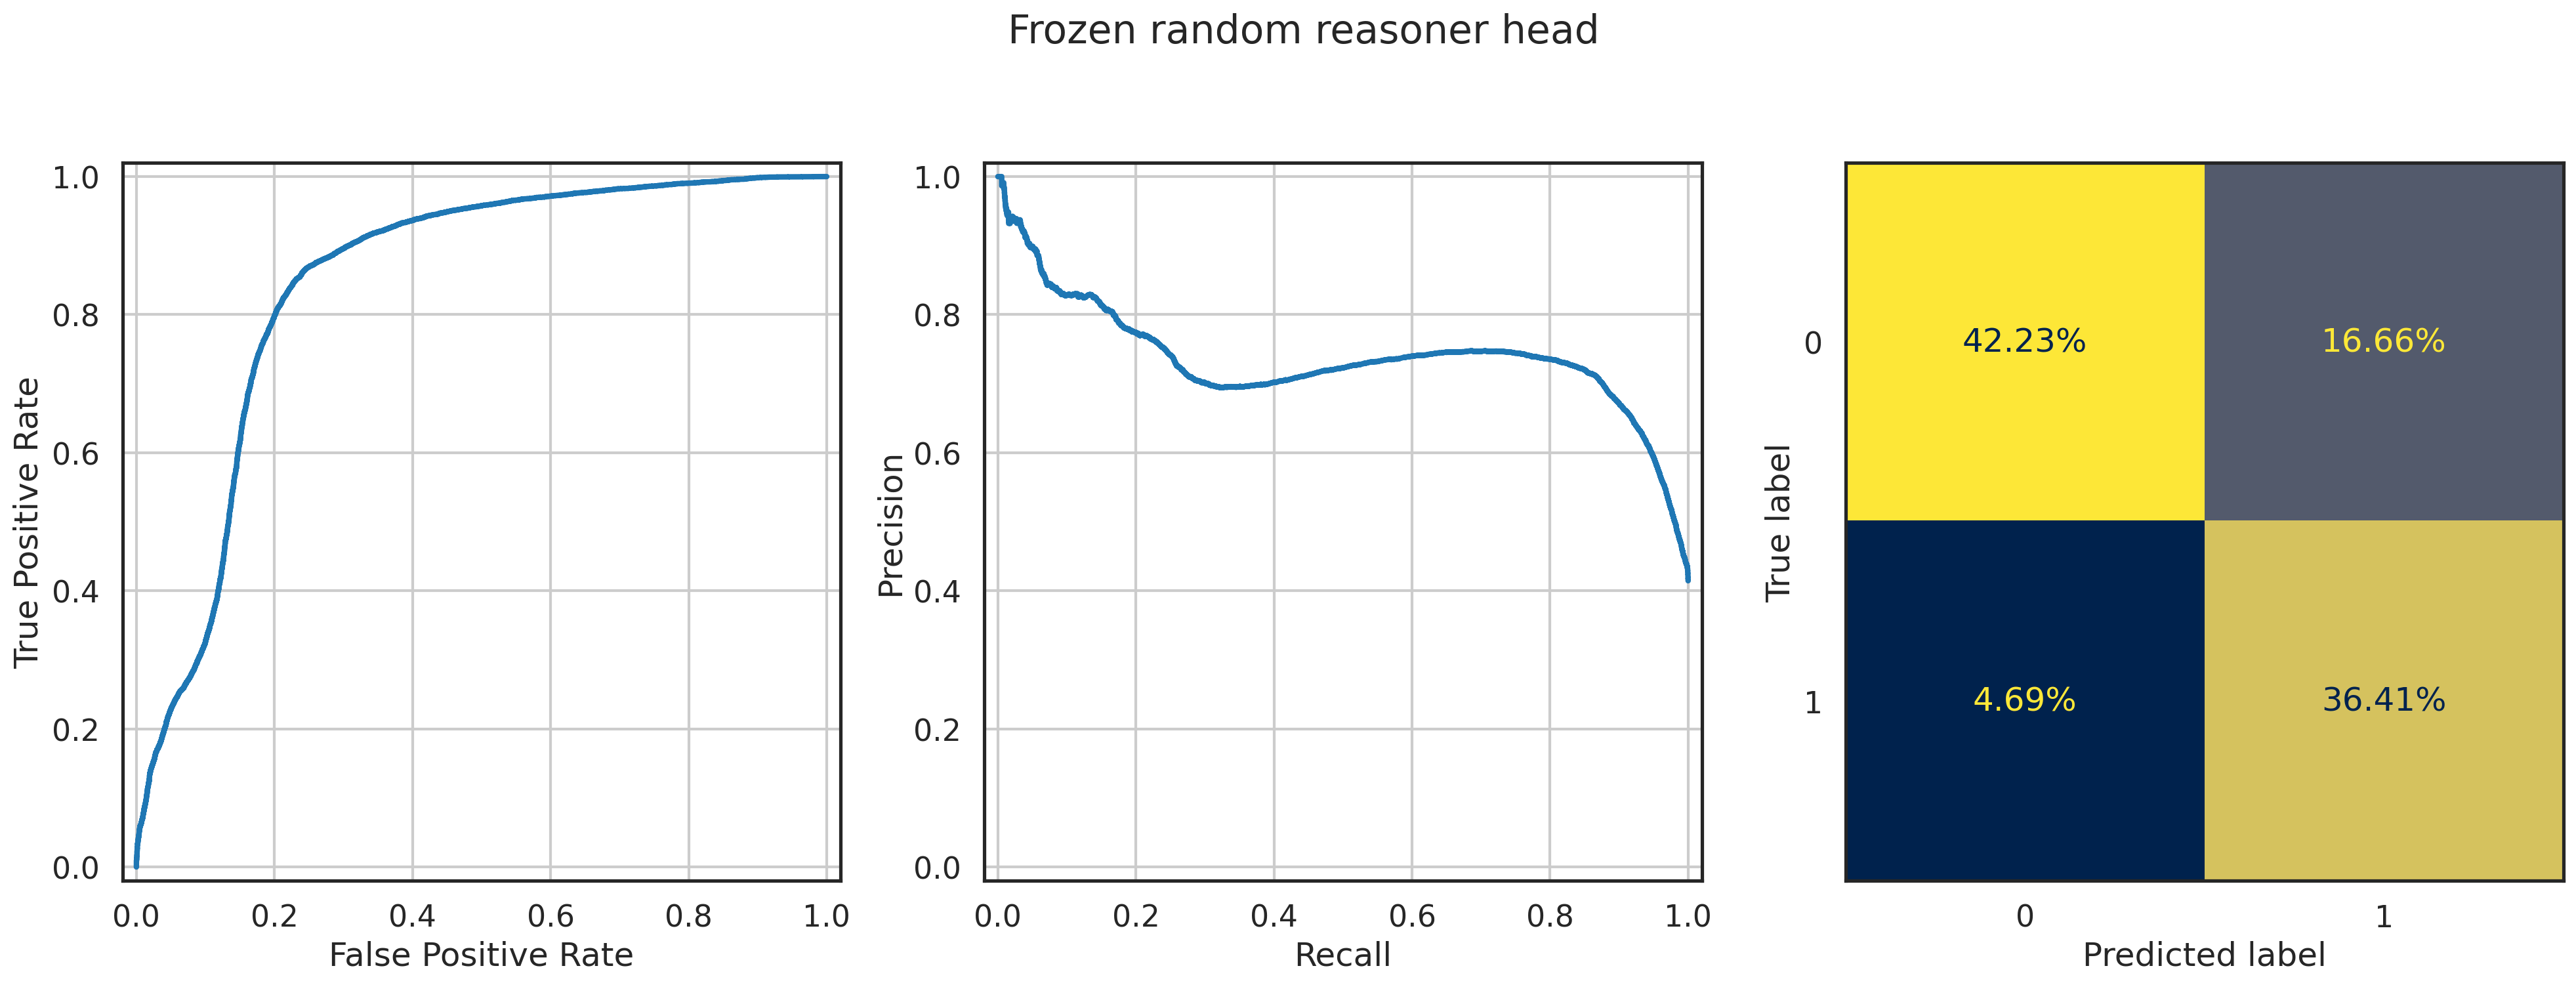

In [8]:
titles = 'Expected', 'Unfrozen reasoner head', 'Frozen pre-trained reasoner head', 'Frozen random reasoner head'
logs = unfrozen_log, transfer_log, random_log
reasoners = unfrozen_r, transfer_r, random_r

for reasoner, log, title in zip(reasoners, logs, titles[1:]):
    print('------')
    with T.no_grad():
        reasoner.eval()
        _, _, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)
    print(title)
    print('train time', pd.DataFrame(log.history_tr).groupby('epoch').max().elapsed.sum())
    print(report([onto], y_te, Y_te, idx_te))
    plt.suptitle(title)

In [9]:
xs = sorted(list(range(onto.n_concepts)), key=lambda i: onto.concepts[i])
ticks = [onto.render(x).replace('Topping', 'T') for x in xs]
n = len(xs)

mats = np.zeros((4, n, n))
for i, c in enumerate(xs):
    for j, d in enumerate(xs):
        mats[0][i][j] = fact.check_sub(c, d)
        mats[1][i][j] = unfrozen_r.check_sub(c, d)
        mats[2][i][j] = transfer_r.check_sub(c, d)
        mats[3][i][j] = random_r.check_sub(c, d)
        
fig, axs = plt.subplots(ncols=4, figsize=(22, 10))
for ax, mat, title in zip(axs, mats, titles):
    sns.heatmap(mat, xticklabels=ticks, yticklabels=ticks, cbar=False, square=True, cmap='cividis', ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.grid(True)
plt.show()

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not tuple

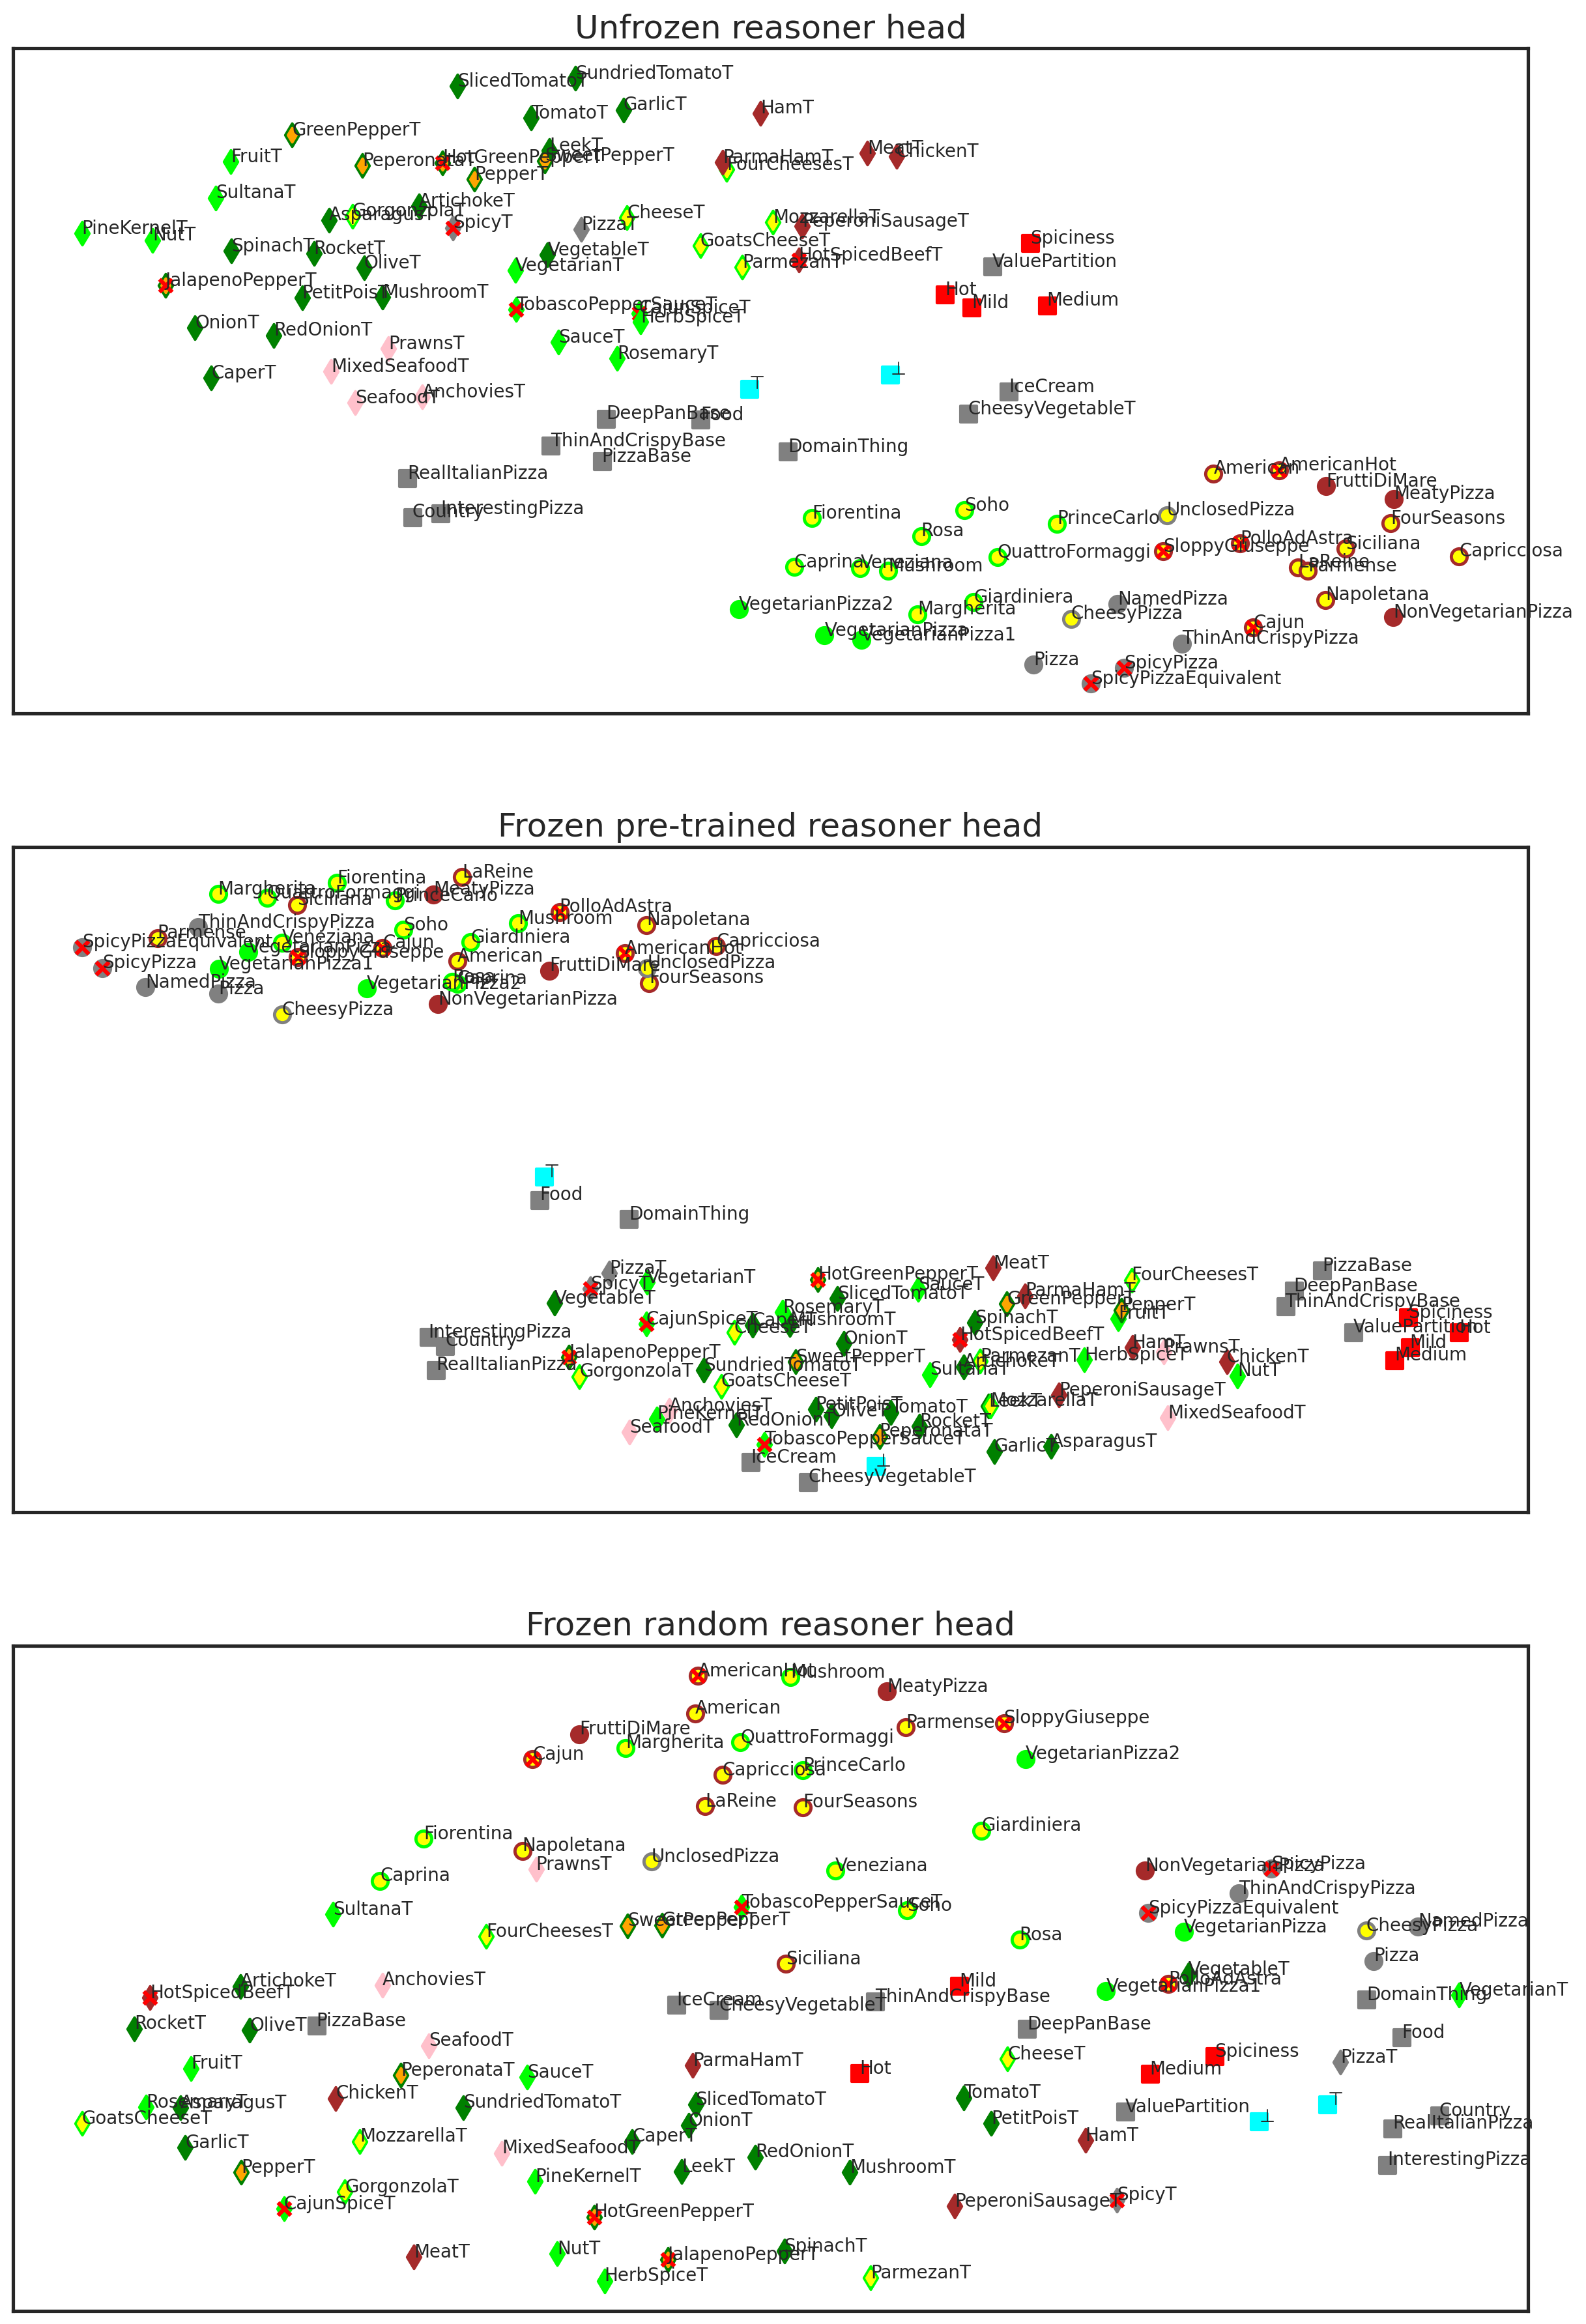

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 23))
for ax, reasoner, title in zip(axs, reasoners, titles[1:]):
    min_dist = 0.3
    vis_pizza(onto, fact, reasoner, min_dist=min_dist, reload_pca=True, seed=seed, ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()